In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)

In [2]:
data = pd.read_csv('./data/district_covariates/all_covariates_clustered.csv')
data.head()

district  reg_year  reg_month  count_lag_month  count_lag_year  count  \
0     Agra      2016          1             1235            1235   1235   
1     Agra      2016          2             1235            1192   1192   
2     Agra      2016          3             1192            1160   1160   
3     Agra      2016          4             1160            1160   1160   
4     Agra      2016          5             1160            1409   1409   

   male_15_24yr_2011  total_population_2011  sex_ratio_2011  total_non_worker  \
0           588704.0              4558268.0           844.0         3028953.0   
1           588704.0              4558268.0           844.0         3028953.0   
2           588704.0              4558268.0           844.0         3028953.0   
3           588704.0              4558268.0           844.0         3028953.0   
4           588704.0              4558268.0           844.0         3028953.0   

   gdp_2011_12  class  
0     13058.94      2  
1     13058.94      2  
2     13058.94      2  
3     13058.94      2  
4     13058.94      2

#### Normalizing

In [3]:
# removing columns that dont need normalisation
cols = data.columns
normalise_cols = list(set(cols)-set(['count', 'district', 'class', 'count_lag_year'
                                     , 'count_lag_month', 'reg_month', 'reg_year', 'sex_ratio_2011']))
# normalising columns
df = data.copy()
for colname in normalise_cols:
    df[colname] = (data[colname] - data[colname].min())/(data[colname].max() - data[colname].min())
data = df.copy()
data.head()

district  reg_year  reg_month  count_lag_month  count_lag_year  count  \
0     Agra      2016          1             1235            1235   1235   
1     Agra      2016          2             1235            1192   1192   
2     Agra      2016          3             1192            1160   1160   
3     Agra      2016          4             1160            1160   1160   
4     Agra      2016          5             1160            1409   1409   

   male_15_24yr_2011  total_population_2011  sex_ratio_2011  total_non_worker  \
0           0.790661               0.734132           844.0           0.75468   
1           0.790661               0.734132           844.0           0.75468   
2           0.790661               0.734132           844.0           0.75468   
3           0.790661               0.734132           844.0           0.75468   
4           0.790661               0.734132           844.0           0.75468   

   gdp_2011_12  class  
0     0.707565      2  
1     0.707565      2  
2     0.707565      2  
3     0.707565      2  
4     0.707565      2

In [4]:
districts = data['district'].unique()                      # 'districts' contains list of unique districts names
num_districts = len(districts)                             # 'num_districts' contains no. of unique districts
dist_lookup = dict(zip(districts, range(num_districts)))   # 'dist_lookup' is a dict, ex. ['agra':0, ... ]
districts_code_all = data['district_code'] = data.district.replace(dist_lookup).values
print('#of districts: ', num_districts)

#of districts:  75


# StanModel

In [5]:
import pystan

In [26]:
try:
    model = pickle.load(open('./model/no_pooling.pkl', 'rb'))
except:
    model_code = """
    data {
        int<lower=1>         N;                      // number of districts
        int<lower=1>         M;                      // number of months
        int<lower=1>         num_attr;               // number of attributes
        int<lower=N>         sigma_error_dof;        // (degree_of_freedom)parameter for inv_wishart prior on sigma_error
        real<lower=0.0>      alpha_mean;                         
        real<lower=0.0>      alpha_variance;
        real<lower=0.0>      beta_mean;
        real<lower=0.0>      beta_variance;
        real<lower=0.0>      error_variance;   // diagonal value for matrix, parameter for inv_wishart
        
        matrix[M, num_attr]  X[N];
        vector[N]            crime_count[M];
    }

    parameters {
        vector[N]            alpha;
        vector[num_attr]     beta[N];
    }

    transformed parameters {
        vector[N]            crime_count_hat[M];
        for(j in 1:N) {
            for(t in 1:M) {
                crime_count_hat[t, j] = alpha[j] + dot_product(X[j, t], beta[j]);
            }
        }
    }
    
    model {
        for(j in 1:N){
            alpha[j]       ~    normal(alpha_mean, alpha_variance);
            beta[j]        ~    multi_normal(rep_vector(beta_mean, num_attr), diag_matrix(rep_vector(beta_variance,num_attr)));
        }
        for(j in 1:N) {
            for(t in 1:M) {
                 crime_count[t, j] ~  normal(crime_count_hat[t, j], error_variance);
            }
        }
    }
    """
    model = pystan.model.StanModel(model_code=model_code, model_name='no_pooling')
    with open('./model/no_pooling.pkl', 'wb') as f:
        pickle.dump(model, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL no_pooling_ee43319058394e79323c1c99c4a95de2 NOW.


In [13]:
def getCluster(num):
    if num is not -1:
        return  data[data['class']==num]
    else:
        return data.copy()

def getTrainTestDataFor(cluster, train_month, test_month):
    dist_nms = cluster['district'].unique()
    cols = ['male_15_24yr_2011', 'total_population_2011', 'total_non_worker', 'gdp_2011_12', 'count_lag_month', 'count_lag_year']
    #cols = ['sex_ratio_2011', 'male_15_24yr_2011', 'total_non_worker', 'gdp_2011_12', 'count_lag_month', 'count_lag_year']
    x_data = []
    y_data = []
    for dn in dist_nms:
        x_data.append(data[data['district'] == dn][cols].values)
        y_data.append(data[data['district'] == dn]['count'].values)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    return x_data[::,:train_month,::], y_data[:,:train_month], x_data[::,-test_month:,::], y_data[:,-test_month:]

def plotgraph(actual, predicted, months, years, clust_num, title, save, df):
    numPlots = predicted.size/12
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)
    for i in range(int(numPlots)):
        index = i*12
        plt.subplot(130+i+1)
        plt.plot(months[index:index+12], actual[index:index+12], label='Actual')
        plt.plot(months[index:index+12], predicted[index:index+12], label='Predicted')
        mse = mean_squared_error(actual[index:index+12], predicted[index:index+12])
        df.loc[df['district'] == title, [str(np.unique(years[index:index+12])[0])]] = int(mse)
        plt.legend()
        plt.title(str(np.unique(years[index:index+12])) + ' mse: ' + str(int(mse)))
    plt.subplots_adjust(top=0.80)
    if save:
        plt.savefig('./images/np/{}.png'.format(title), bbox_inches='tight')
    #plt.close()

In [27]:
cluster_num     = -1
training_months = 24
testing_months  = 36

clust    = getCluster(cluster_num)
dist_nms = clust['district'].unique()
X_train, Y_train, X_test, Y_test = getTrainTestDataFor(clust, training_months, testing_months)
print('Shape of X_train, Y_train, X_test, Y_test')
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print('Number of districts: ', dist_nms.size)

Shape of X_train, Y_train, X_test, Y_test
(75, 24, 6) (75, 24) (75, 36, 6) (75, 36)
Number of districts:  75


In [28]:
num_attr              = X_train.shape[2]
sigma_error_dof       = dist_nms.size           # should be >= 0
alpha_mean            = 0.0                     # should be >= 0
alpha_variance        = 10.0                   # should be >= 0
beta_mean             = 0.0                     # should be >= 0
beta_variance         = 50                    # should be >= 0
error_variance        = 2                    # should be >= 0

In [29]:
data_dict = {
    'N'                    : dist_nms.size,                  #Number of districts
    'M'                    : training_months,                #Number of training months
    'num_attr'             : num_attr,
    'sigma_error_dof'      : sigma_error_dof,
    'alpha_mean'           : alpha_mean,
    'alpha_variance'       : alpha_variance,
    'beta_mean'            : beta_mean,
    'beta_variance'        : beta_variance,
    'error_variance'       : error_variance,
    'X'                    : X_train,
    'crime_count'          : Y_train.T
}

In [30]:
model_fit = model.sampling(data=data_dict, iter=1000, chains=6, warmup=400, n_jobs=-1, seed=np.random.randint(100), 
                  control=dict(max_treedepth=12, adapt_delta=0.80), check_hmc_diagnostics=True)

In [31]:
beta = np.mean(model_fit.extract()['beta'], axis = 0)
alpha = np.mean(model_fit.extract()['alpha'], axis = 0)
print(alpha.shape, beta.shape)
print(alpha, '\n', beta)

(75,) (75, 6)
[ -71.6216802  -455.1510818   -11.65319532  -25.43386174  112.30097138
  -48.59282234   -1.87919781    4.21748514 -160.48496081   41.95089834
   48.17676178   30.57010877   -5.57771214   92.11007251  116.14261141
  -20.73865514   56.36684668  277.6745436   -26.85474995  -25.63178967
  -17.9227564    61.07556228  128.30309881   -9.61771439 -132.65091557
  186.3951731    14.02610707   54.07118421    9.77302547   42.75244504
    9.36434863  -58.73167561   29.37370749 -121.12200929  -67.44394711
  -71.78168145  -35.87100752 -108.90431159 -107.7994003   -91.81472871
   37.51836714 -177.56098013  -36.92185512   16.96738857  -30.2742936
  -47.96361414    6.56907087   85.94932921   19.35234103   -3.68523665
   35.72951228  150.31046372 -226.74536596   15.11449994 -211.22419404
   55.7490369    98.01602926   56.27601102  -26.20347844  -89.06354342
  -96.40279652   55.40643604   37.39176212  -46.7415691    89.77801551
  -19.60662339  -80.22383965   27.8851559   -23.01951393   44.95

### Prediction and Plots

In [32]:
cols = np.array(['district'])
cols = np.append(cols, clust['reg_year'].unique())
msedf = pd.DataFrame(columns=cols)
msedf['district'] = dist_nms

/home/supriya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/supriya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/supriya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcPa

/home/supriya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/supriya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/supriya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcPa

/home/supriya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/supriya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/supriya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcPa

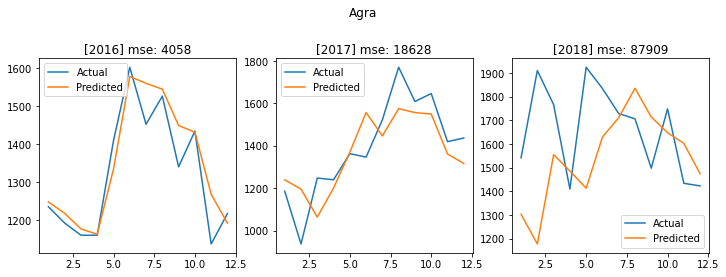

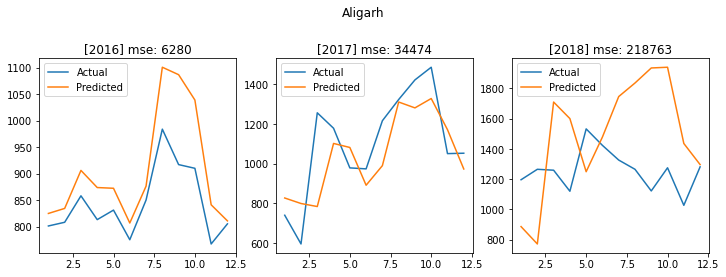

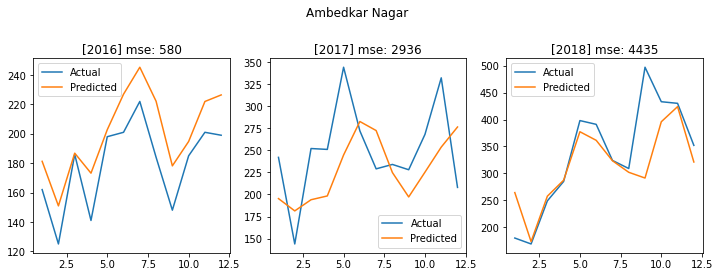

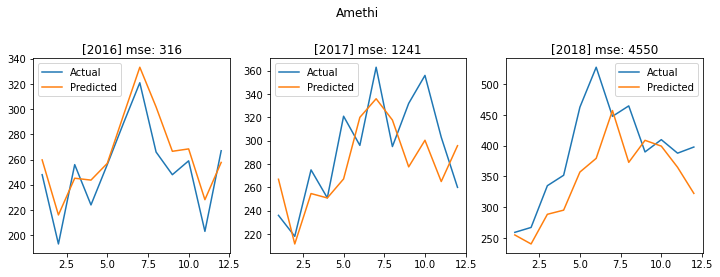

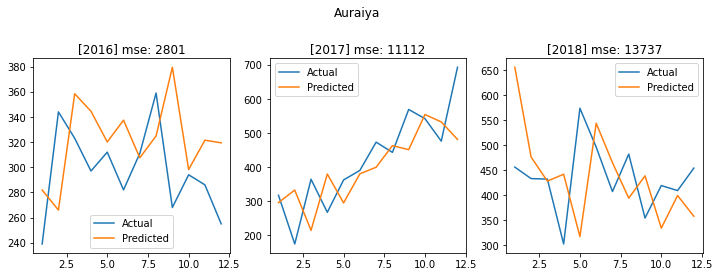

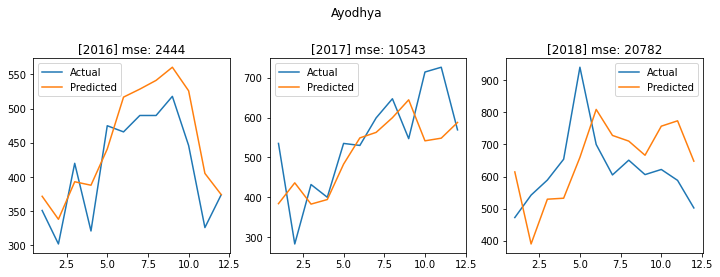

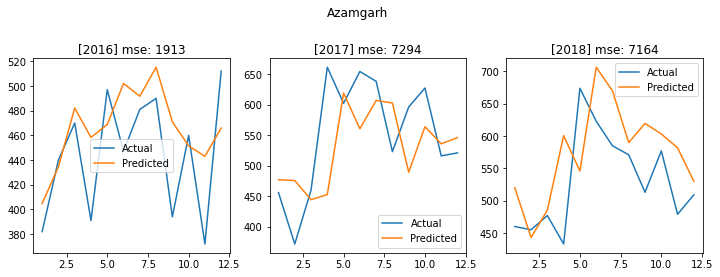

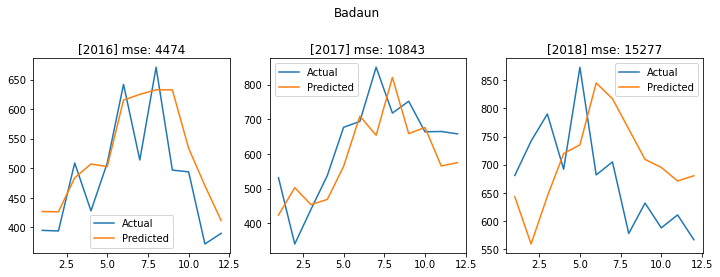

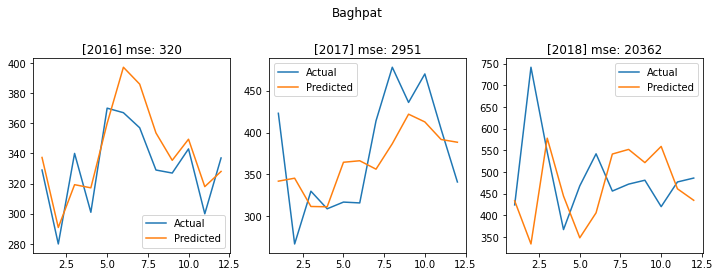

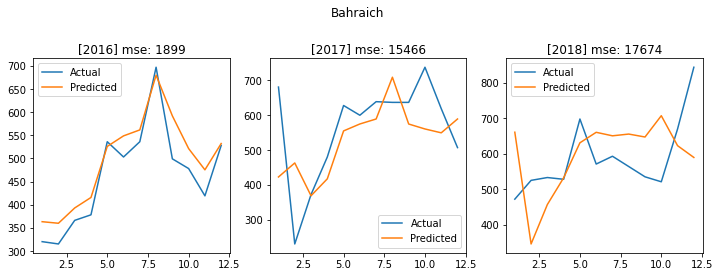

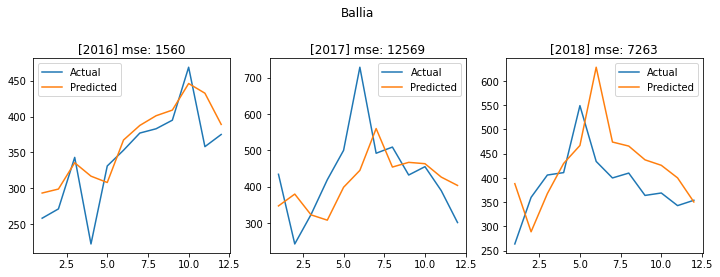

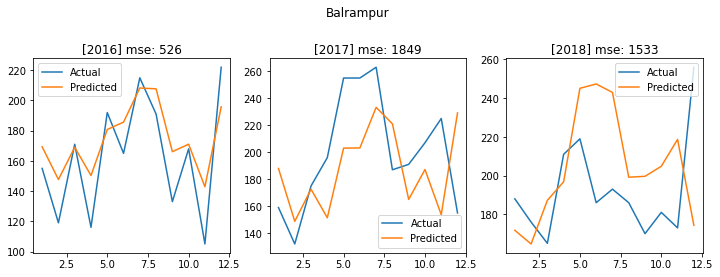

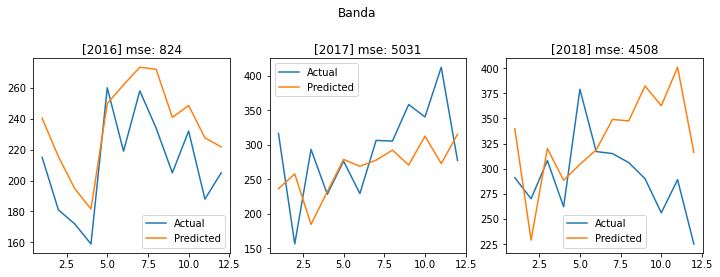

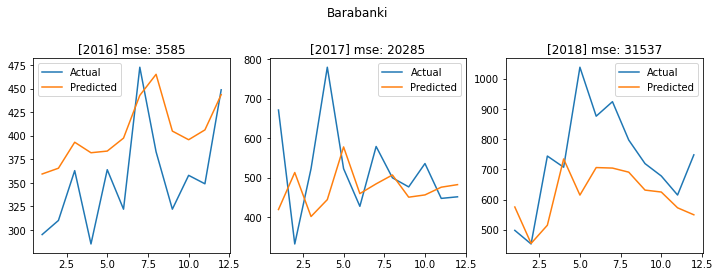

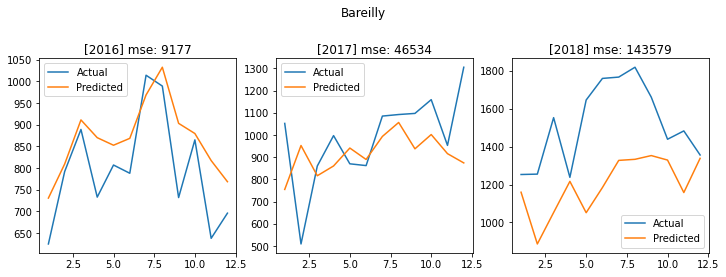

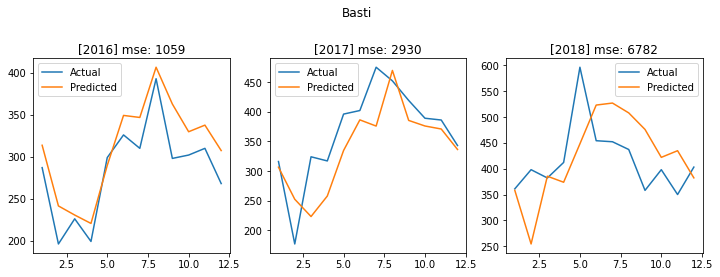

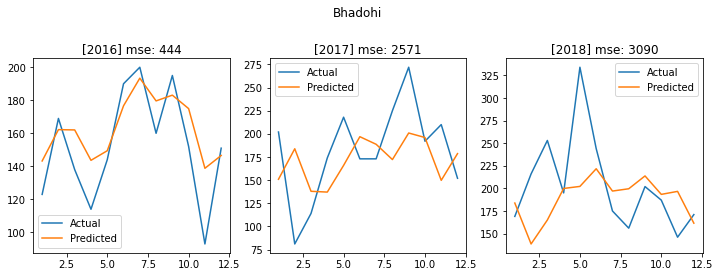

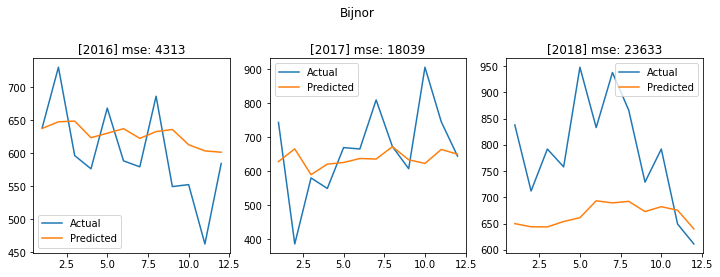

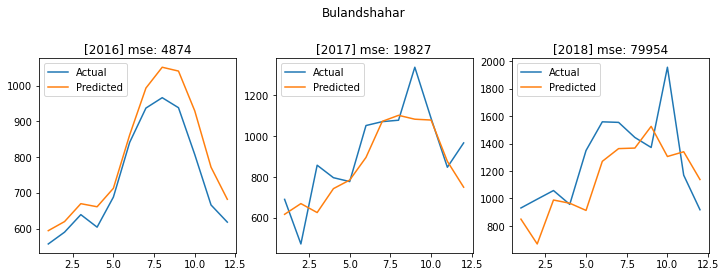

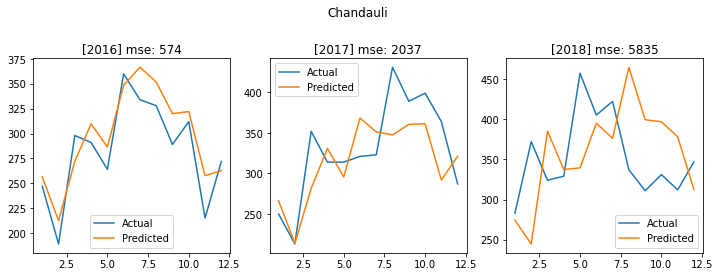

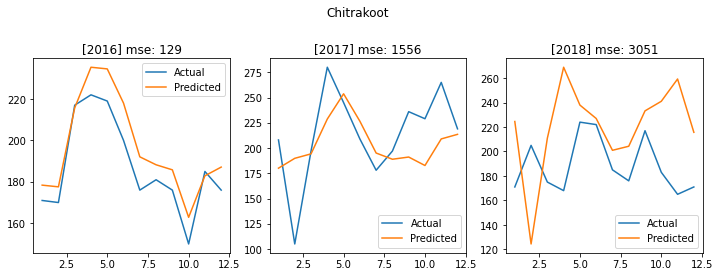

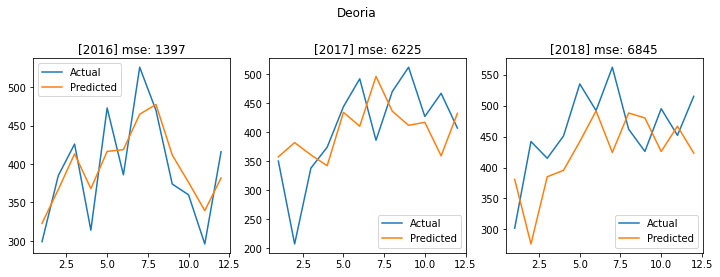

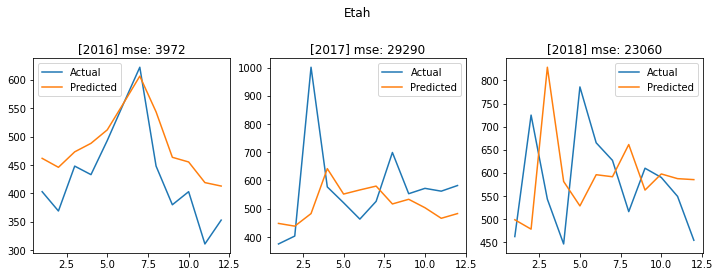

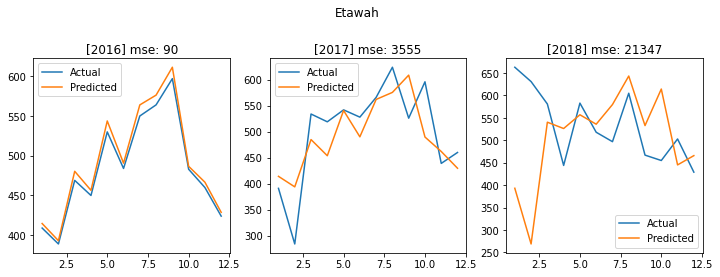

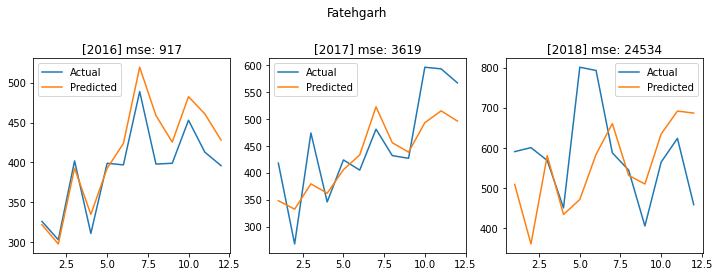

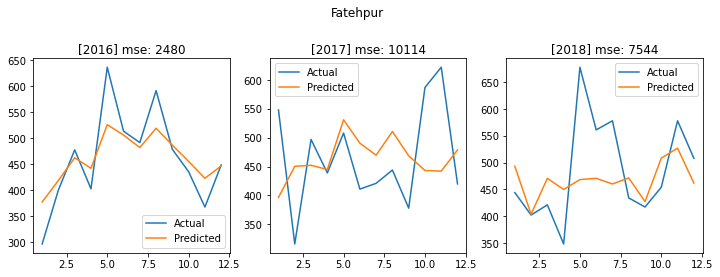

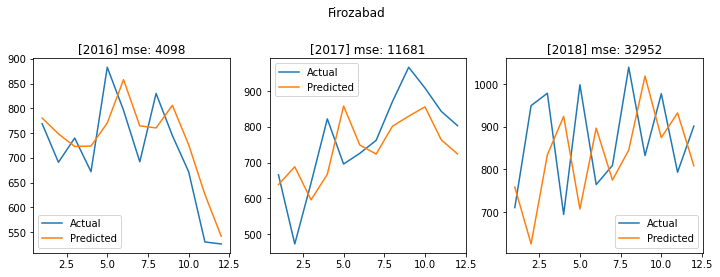

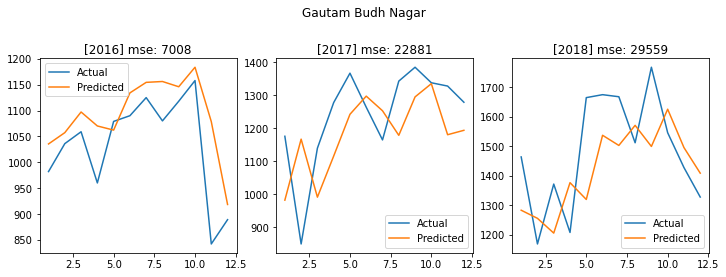

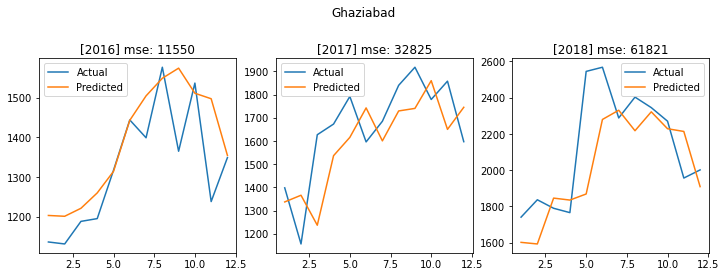

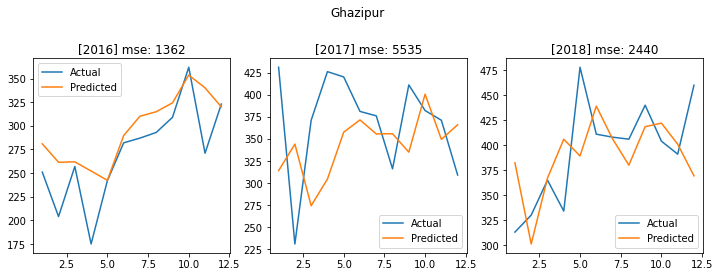

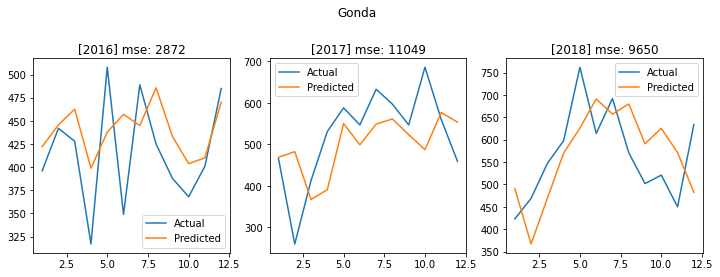

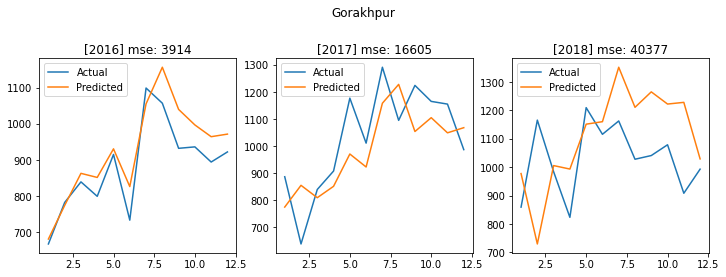

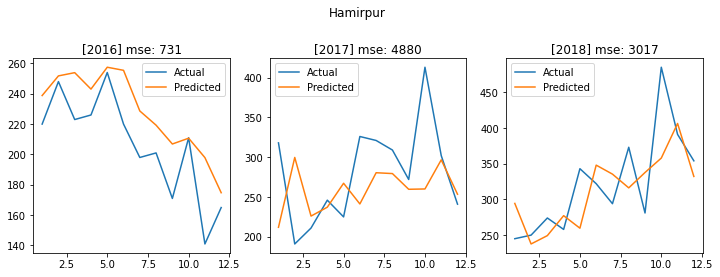

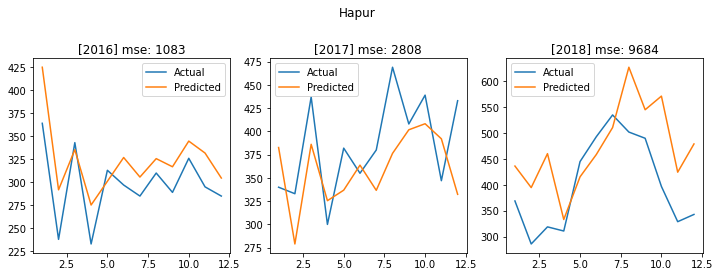

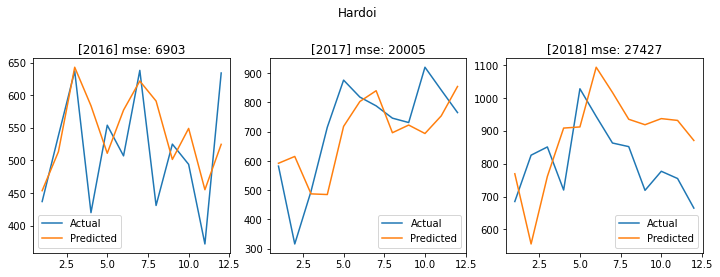

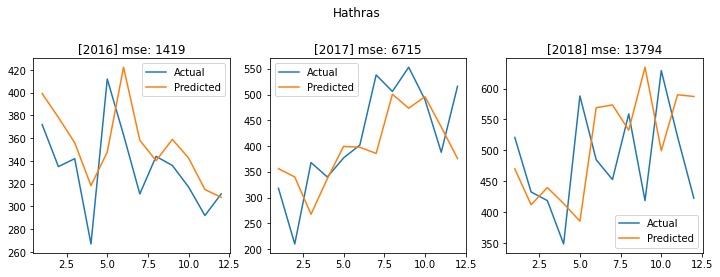

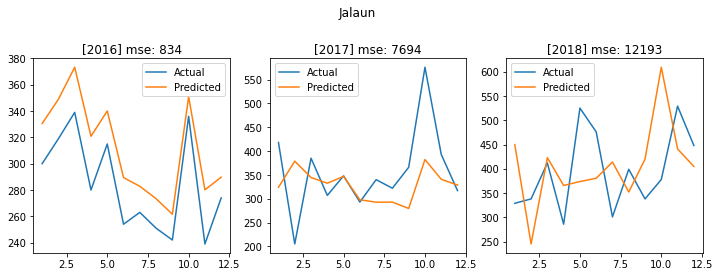

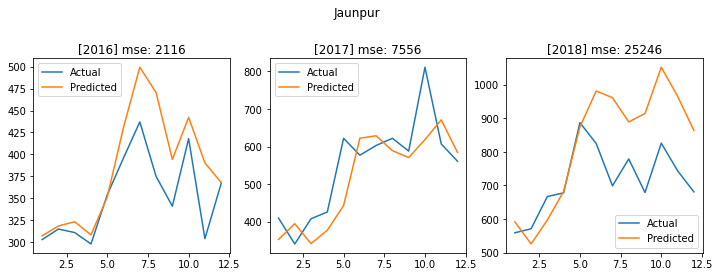

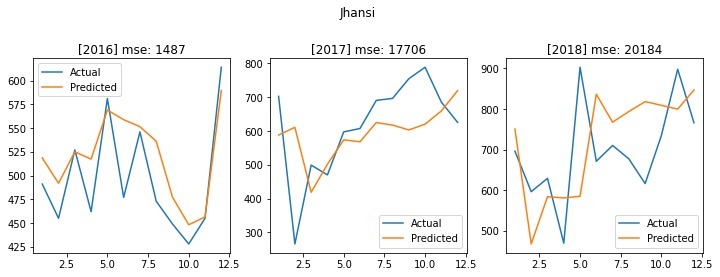

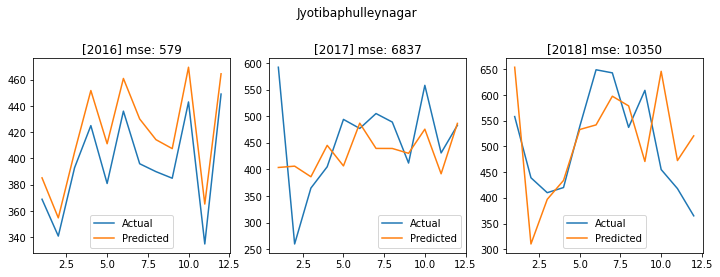

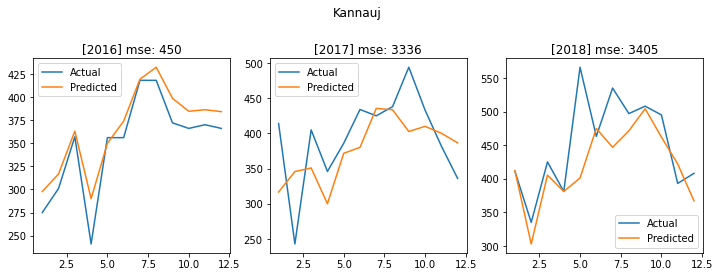

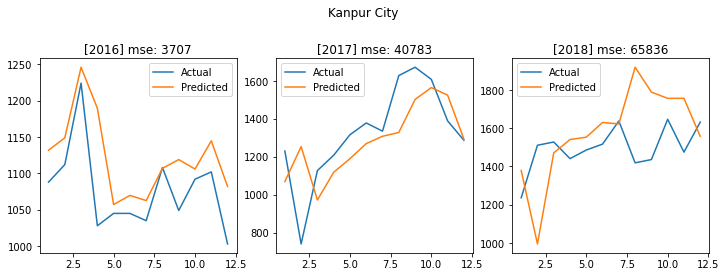

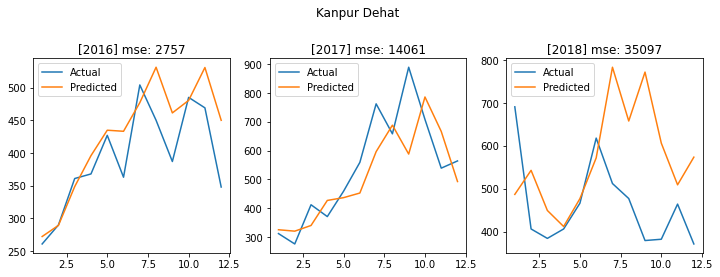

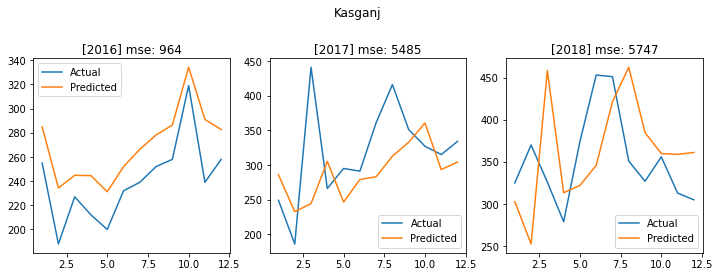

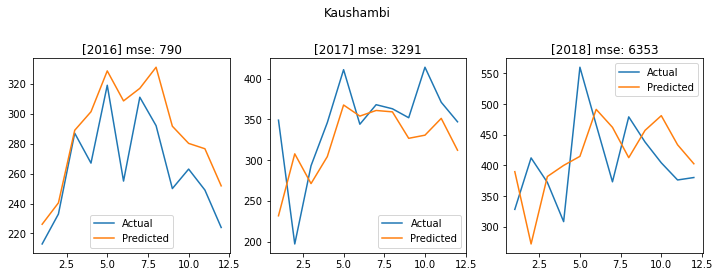

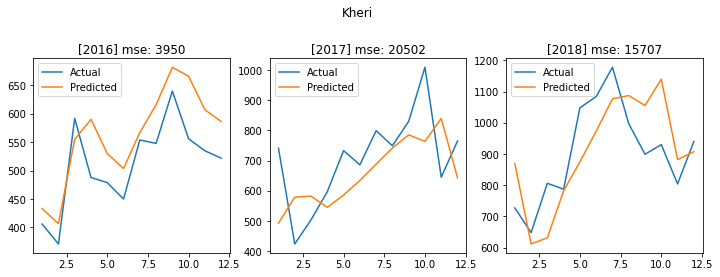

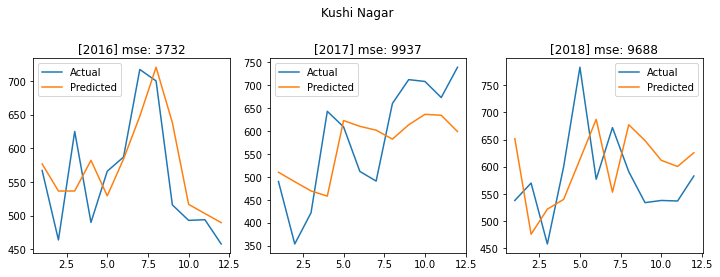

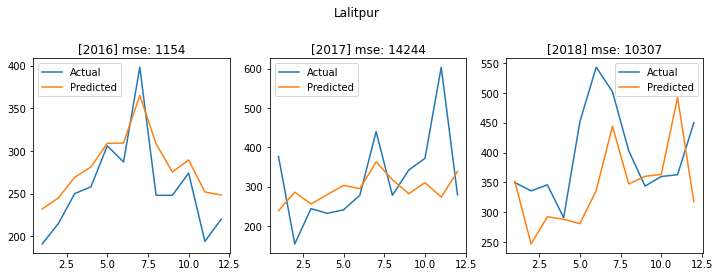

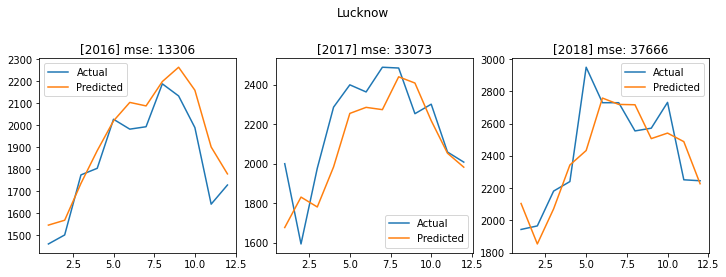

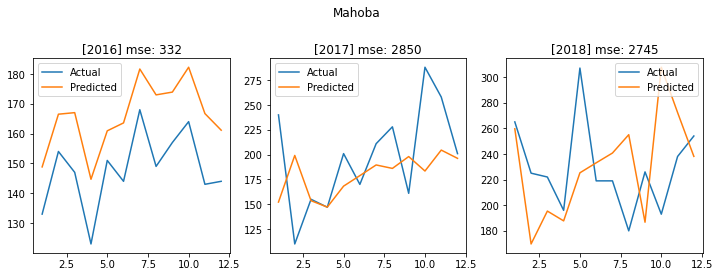

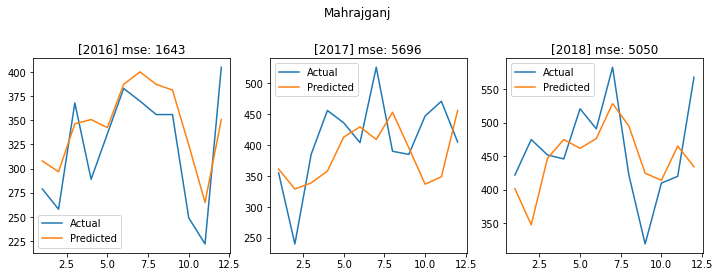

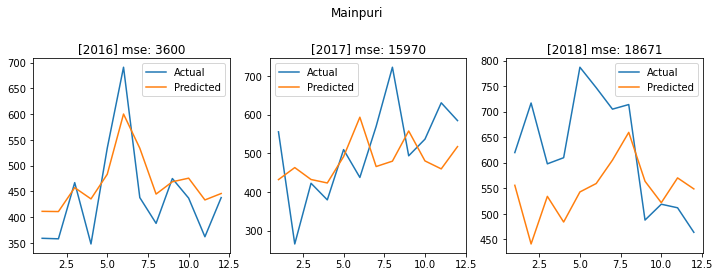

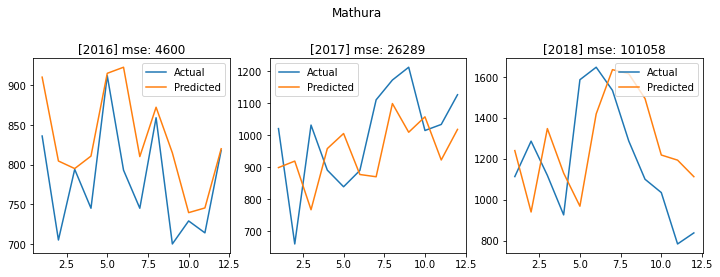

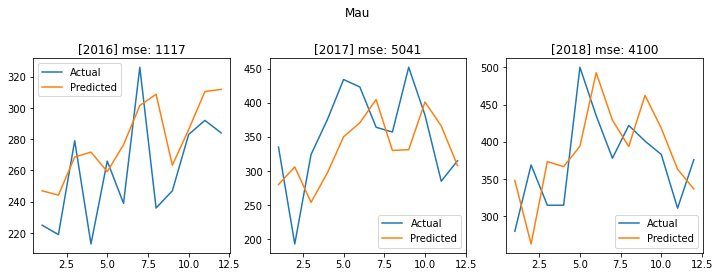

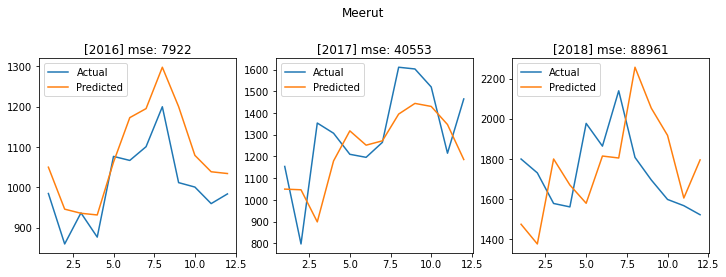

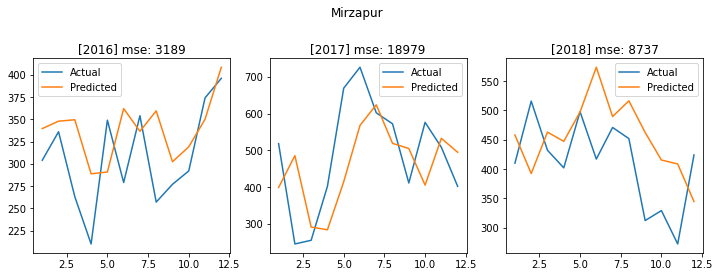

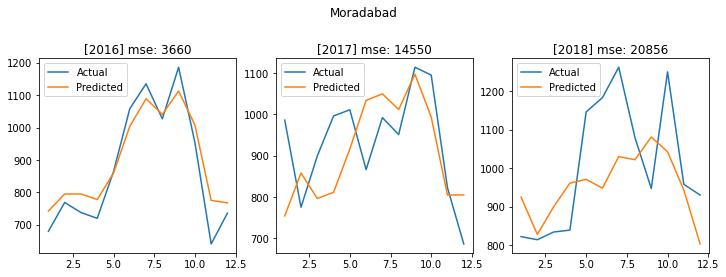

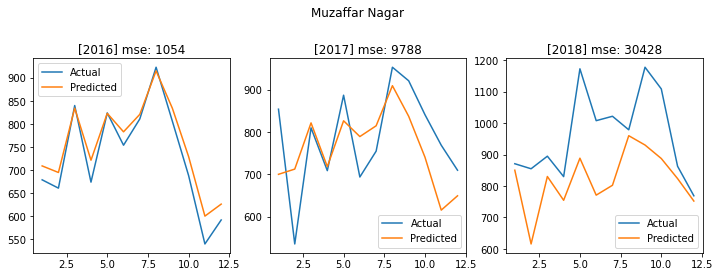

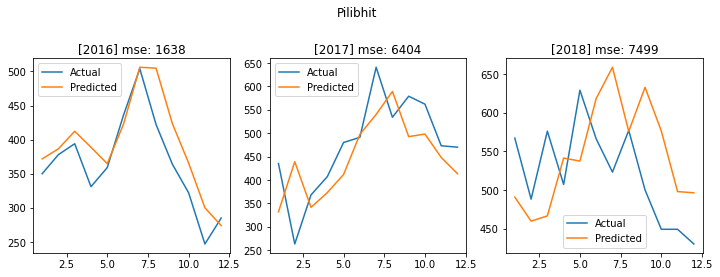

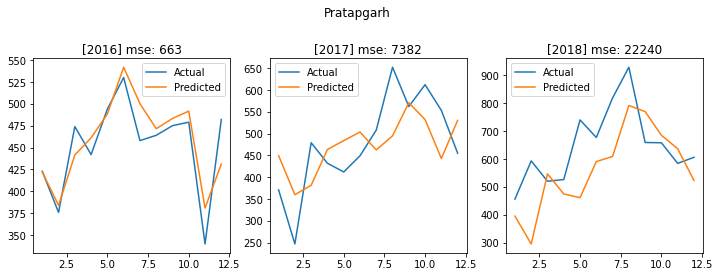

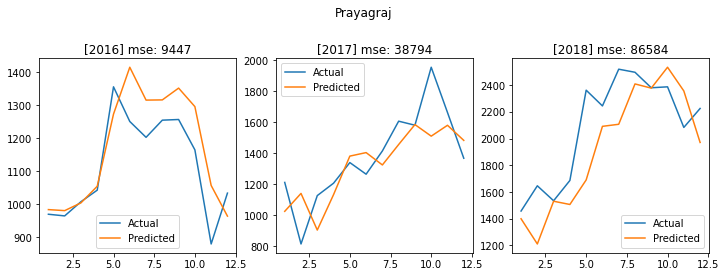

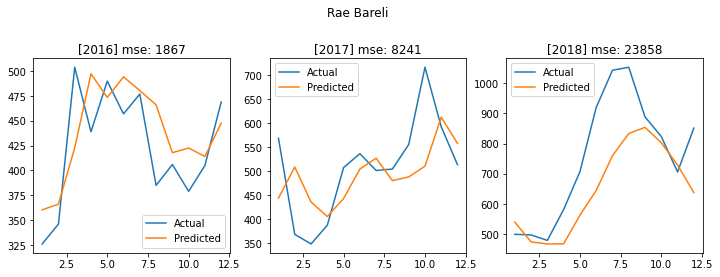

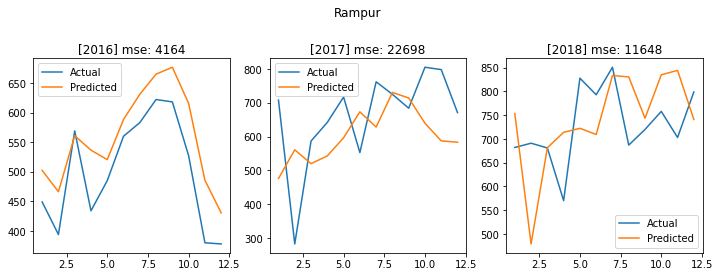

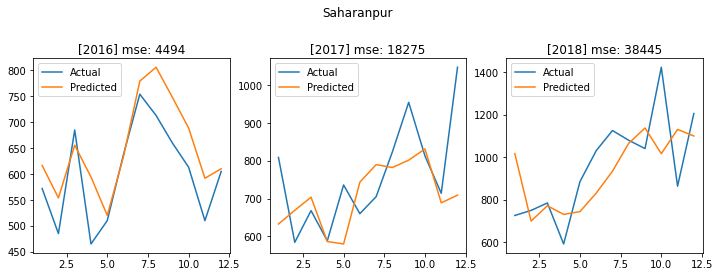

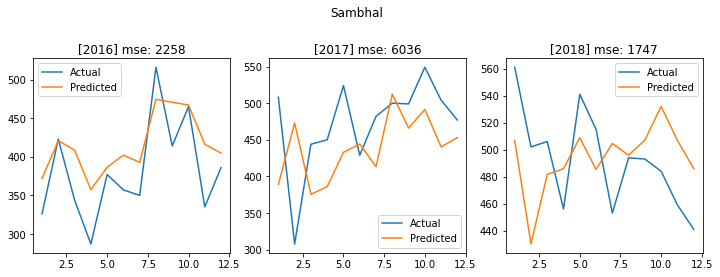

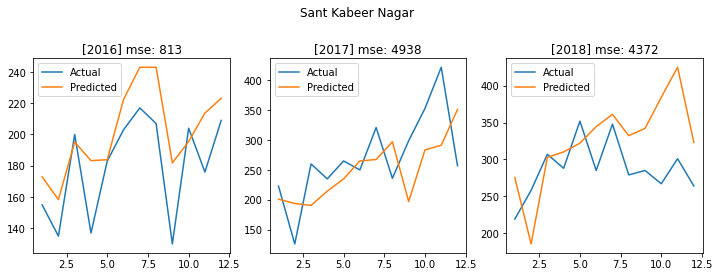

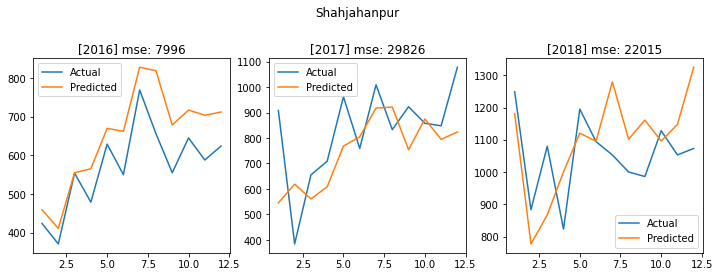

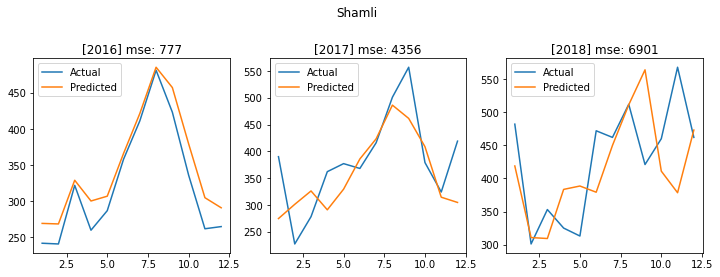

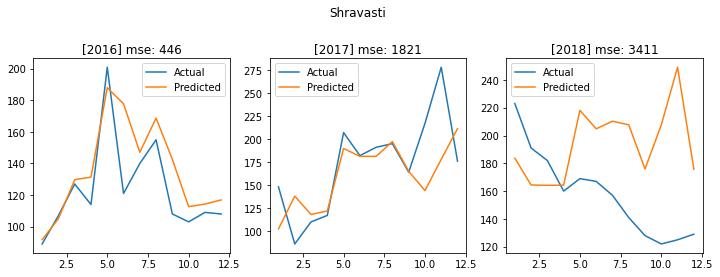

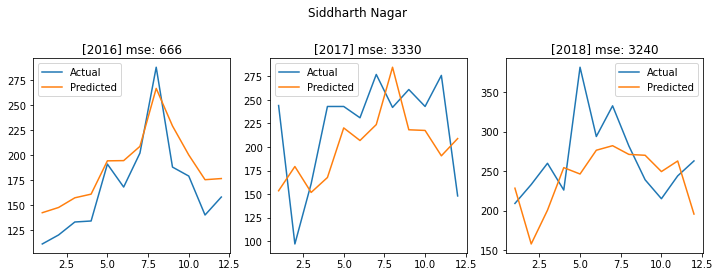

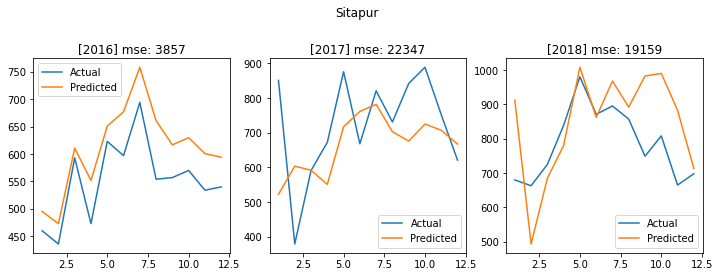

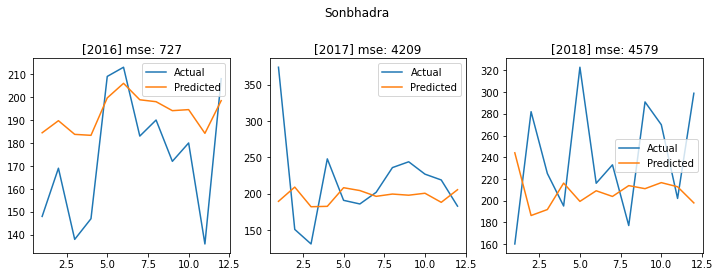

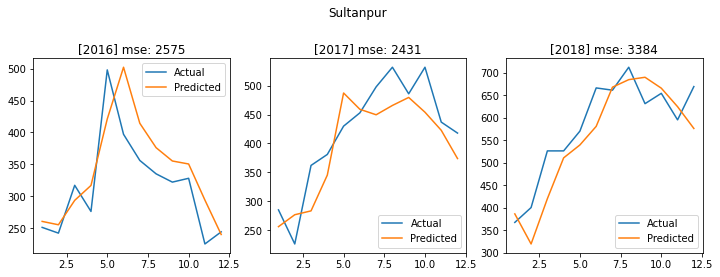

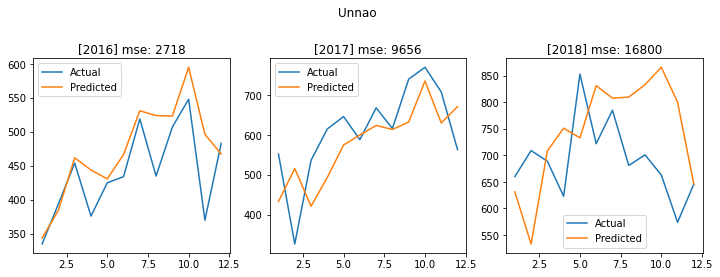

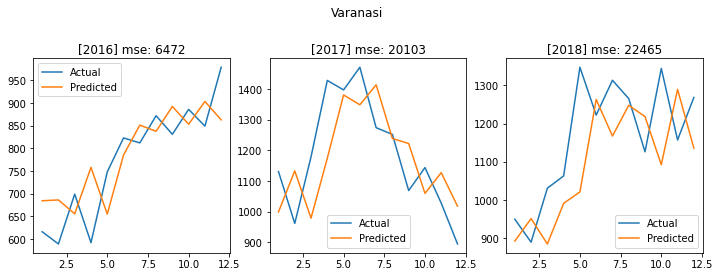

In [33]:
for i in range(dist_nms.size):
    predictions = alpha[i] + X_test[i].dot(beta[i])
    months = clust[clust['district'] == dist_nms[i]]['reg_month'].values
    years = clust[clust['district'] == dist_nms[i]]['reg_year'].values
    plotgraph(Y_test[i], predictions, months, years, cluster_num, dist_nms[i], True, msedf)

In [34]:
plt.close()

In [35]:
msedf.to_csv('./csvs/np/np.csv'.format(cluster_num), index=False)

In [40]:
color = {
    'alpha':'b',
    'b0':'g',
    'b1':'r',
    'b2':'c',
    'b3':'m',
    'b4':'y',
    'b5':'k'
}

In [49]:
def plotbox(data, labels, title, marker):
    fig, ax1 = plt.subplots(figsize=(16, 8))
    fig.canvas.set_window_title('A Boxplot Example')
    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.25)
    
    bp = plt.boxplot(data, notch=0, sym=marker, vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker=marker)
    
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax1.set_axisbelow(True)
    ax1.set_title('Posterior distribution of '+title)
    for i in range(len(label)):
        box = bp['boxes'][i]
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        boxCoords = list(zip(boxX, boxY))

        boxPolygon = Polygon(boxCoords, facecolor='r')
        ax1.add_patch(boxPolygon)
        
    ax1.set_xlim(0, len(label) + 1)
    xtickNames = plt.setp(ax1, xticklabels=label)
    #ax1.set_ylim(0, 1.3)
    plt.setp(xtickNames, rotation=90, fontsize=9)
    plt.savefig('./images/np/{}.png'.format(title))
    plt.show()

In [50]:
districts.shape

(75,)

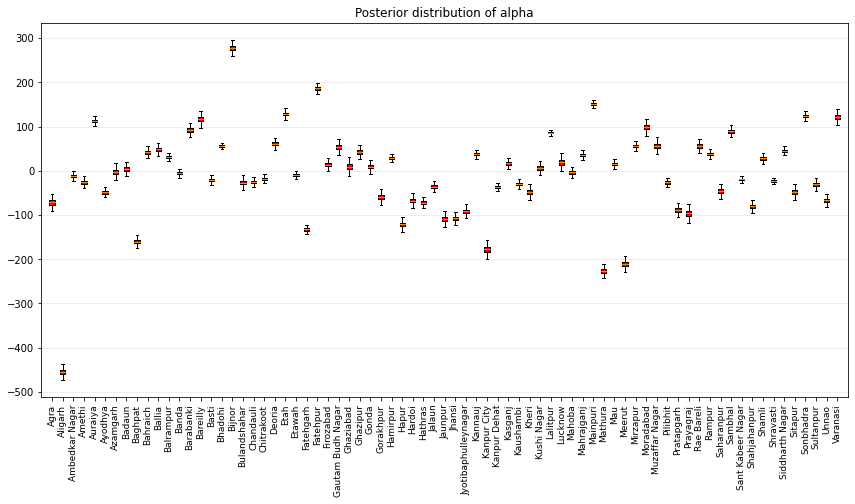

In [51]:
alp = model_fit.extract()['alpha']
label = districts

plotbox(alp, label, 'alpha', '')

In [ ]:
alp = model_fit.extract()['alpha']
label = districts

plotbox(alp, label, 'beta()', '')